# Whole brain data processing

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dir_root = '/nrs/ahrens/jing/giving_up/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/'
dask_tmp = '/opt/data/weiz/dask-worker-space'
memory_limit = 0 # unlimited

nsplit = (8, 16)

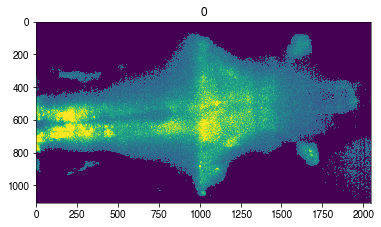

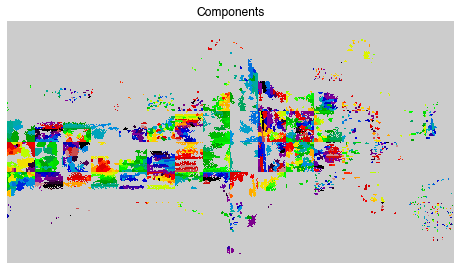

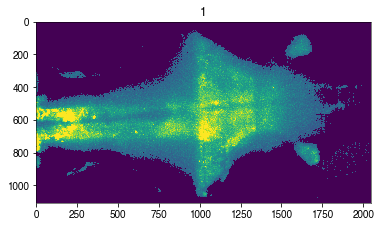

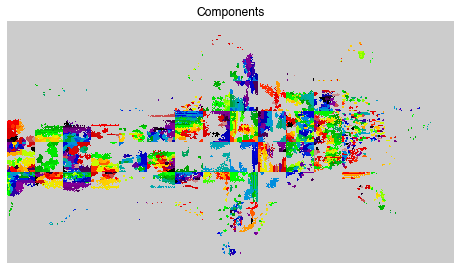

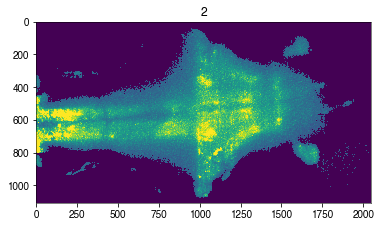

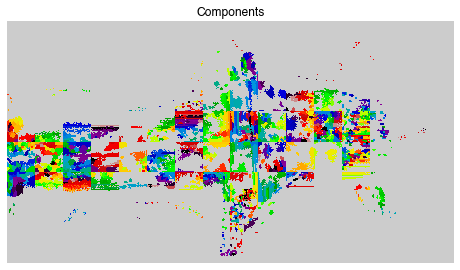

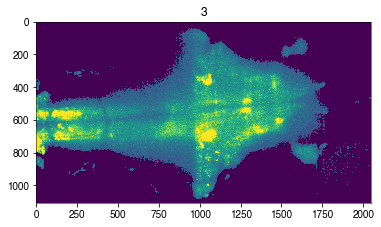

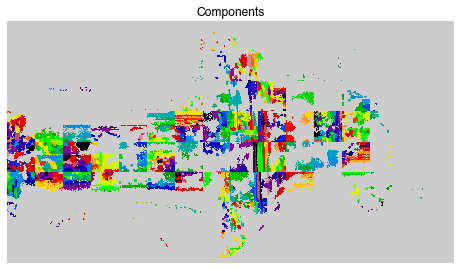

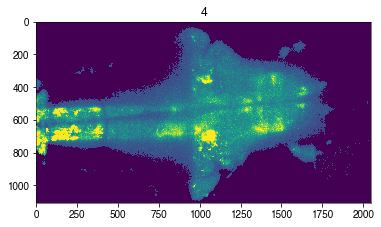

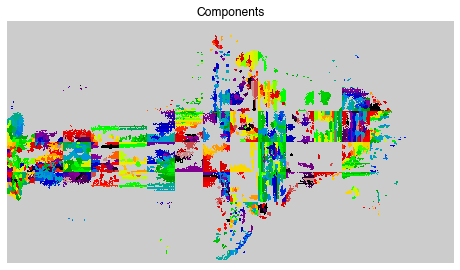

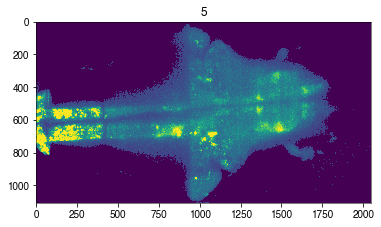

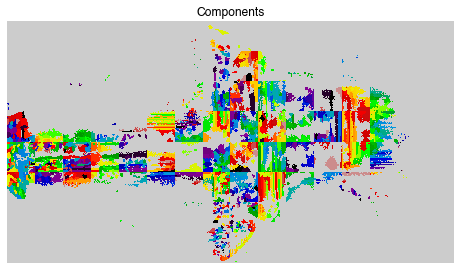

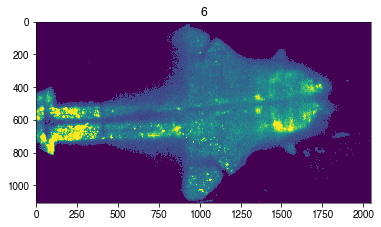

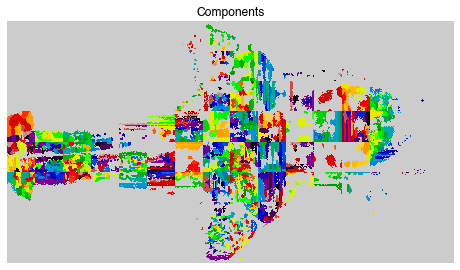

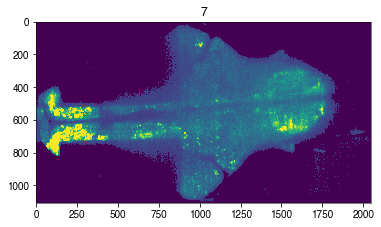

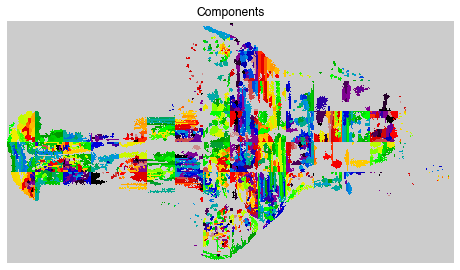

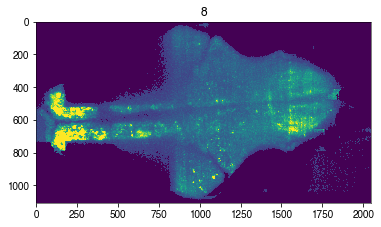

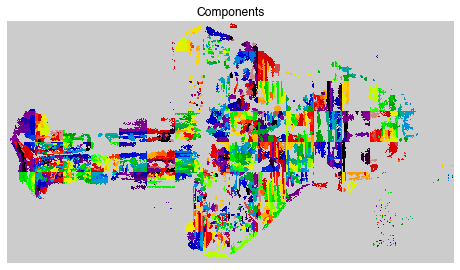

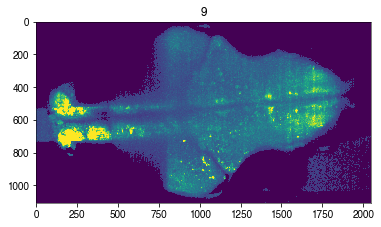

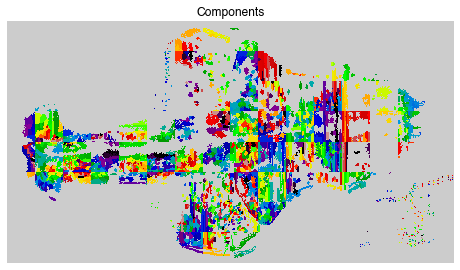

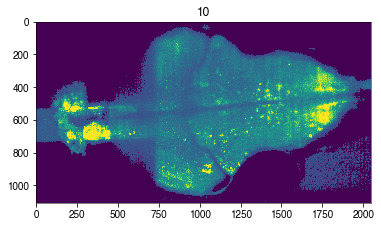

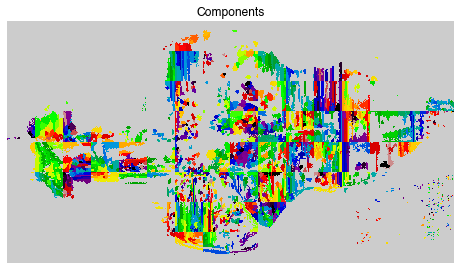

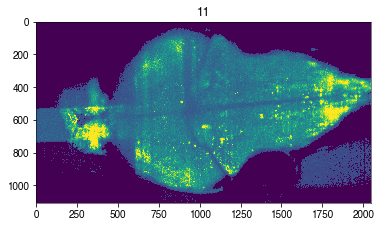

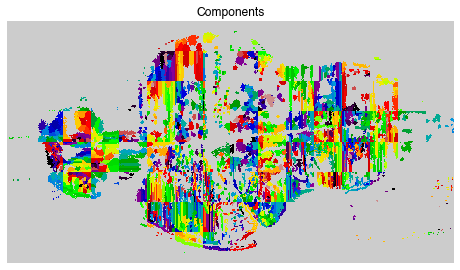

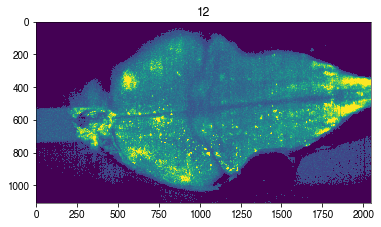

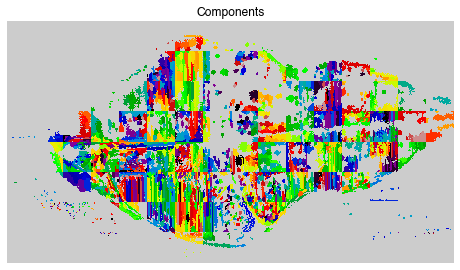

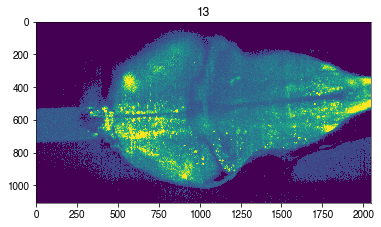

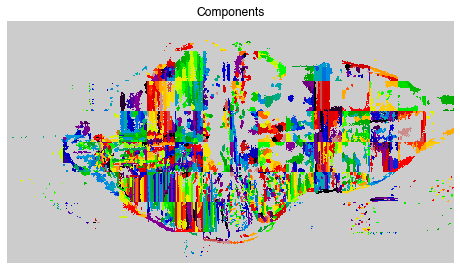

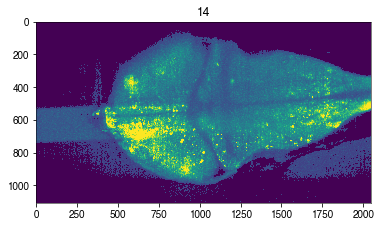

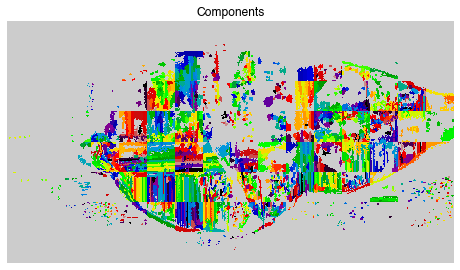

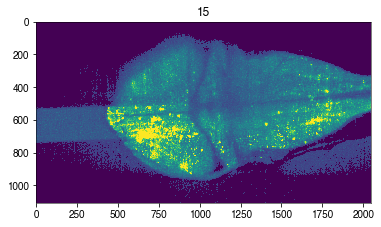

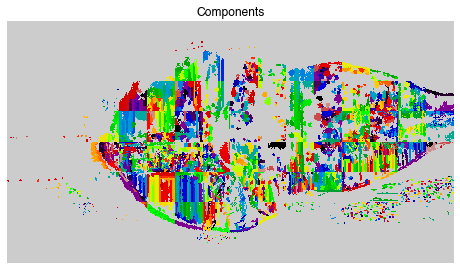

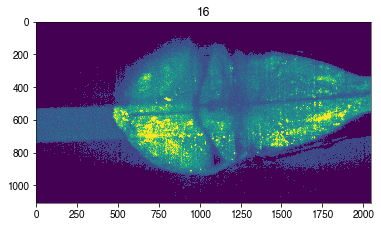

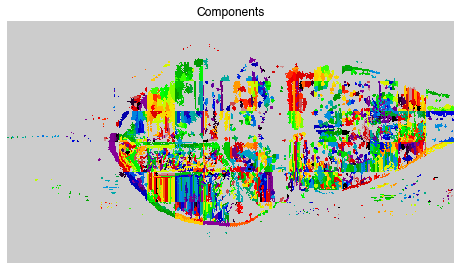

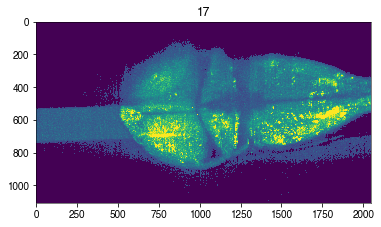

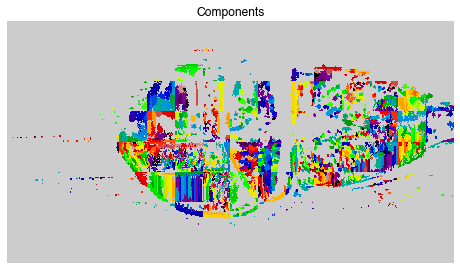

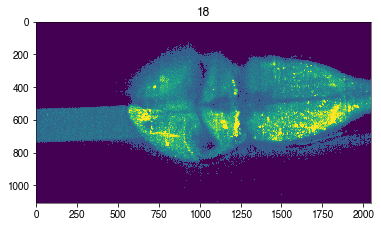

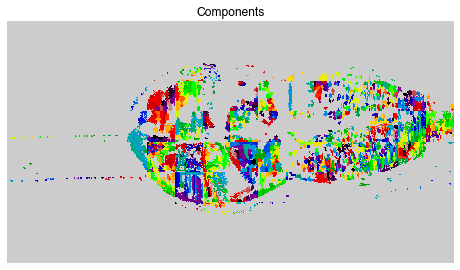

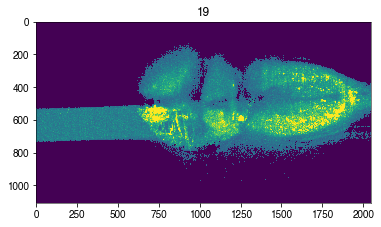

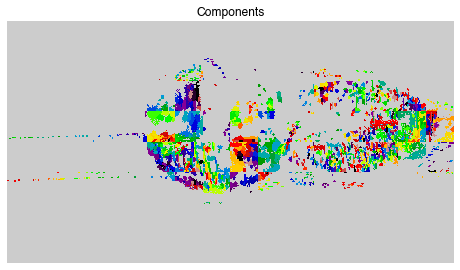

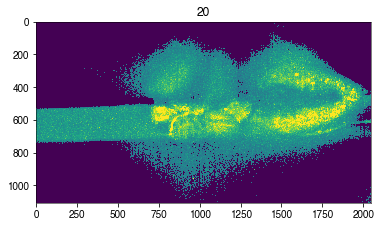

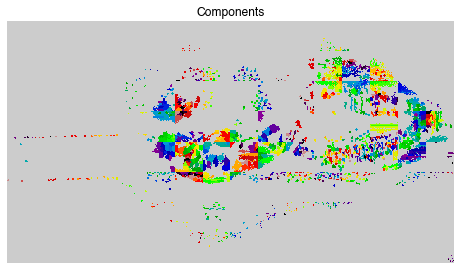

In [3]:
Y_d = zarr.open(f'{save_root}/Y_max.zarr', 'r')
mask = zarr.open(f'{save_root}/mask_map.zarr', 'r')
for n, n_ave_ in enumerate(Y_d):
    _ = n_ave_.squeeze().copy()
    _[~mask[n].squeeze()] = 0
    plt.imshow(_, vmax=np.percentile(_, 99))
    plt.title(n)
    plt.show()
    check_demix_cells_layer(save_root, n, nsplit = nsplit)

## df data after denoising

#### Take one block data for validation of denoise using local correlation

In [ ]:
block_id = (8, 4, 1, 0)

In [ ]:
check_demix_cells(save_root, block_id, plot_global=True, plot_mask=True)

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [ ]:
# dff on raw data
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
baseline_t = da.map_blocks(baseline_from_Yd, trans_data_t, Y_d, dtype='float32')
_, nx, ny, _ = trans_data_t.chunksize
dff = Y_d/baseline_t

# dff on denoised data
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')
dff_ = (Y_svd+Y_d.mean(axis=-1, keepdims=True))/baseline_t

In [ ]:
pix_id = (14, 1432, 909)

plt.figure(figsize=(20, 4))
plt.plot(trans_data_t[pix_id])
plt.plot(baseline_t[pix_id])
# plt.ylim([0, 10])
plt.title('Baseline on raw data')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(Y_d[pix_id])
plt.plot(Y_svd[pix_id])
# plt.ylim([0, 10])
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(dff[pix_id], label='df/f')
plt.plot(dff_[pix_id], label='denoised df/f')
plt.legend()
# plt.ylim([0, 10])
plt.show()

In [ ]:
cluster.stop_all_jobs()

In [ ]:
force_bkill_dask()

### df/f on raw cell data

In [ ]:
numCores = 1400
compute_cell_dff_raw(save_root, numCores=numCores)

In [ ]:
force_bkill_dask()

### df/f on denoised cell data

In [ ]:
numCores = 1400
compute_cell_dff_NMF(save_root, numCores=numCores, dt=dt)

In [ ]:
force_bkill_dask()

### Check df/f on patches

In [ ]:
rand_block = (8, 5, 7, 0)
check_demix_cells(save_root, rand_block, plot_global=False, plot_mask=False)

In [ ]:
from h5py import File

In [ ]:
def fsave_name(save_root, block_id):
    fsave = f'{save_root}/cell_nmf_dff/period_Y_demix_block_'
    for _ in block_id:
        fsave += '_'+str(_)
    return fsave + '_rlt.h5'

In [ ]:
fsave = fsave_name(save_root, rand_block)

In [ ]:
with File(fsave, 'r') as f:
    A = f['A'].value
    F0 = f['cell_F0'].value
    dF = f['cell_dF'].value

In [ ]:
# for n in range(A.shape[-1]):
#     plt.imshow(A[:, :, n].squeeze())
#     plt.title(n)
#     plt.show()

In [ ]:
n = 18
plt.figure(figsize=(8, 8))
plt.imshow(A[:, :, n].squeeze())
plt.title('Components')
plt.show()
plt.figure(figsize=(20, 4))
plt.plot(dF[n]/F0[n])
plt.title('dF/F')
plt.show()

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(dF[n]+F0[n])
plt.plot(F0[n])
plt.title('raw F')
plt.show()

In [ ]:
rand_block = (8, 5, 7, 0)
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
block_data = trans_data_t.blocks[rand_block].compute(scheduler='single-threaded')

In [ ]:
block_data = block_data.squeeze()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FFMpegFileWriter
plt.rcParams['animation.ffmpeg_path'] = '/groups/ahrens/home/weiz/anaconda/envs/myenv/bin/ffmpeg'

In [ ]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_axis_off()
axs.set_xticklabels([])
axs.set_yticklabels([])
min_ = np.percentile(block_data, 0.1)
max_ = np.percentile(block_data, 99.9)
imgs = axs.imshow(block_data[:, :, 0], vmin=min_, vmax=max_, cmap="Greys_r")

def update(i):
    imgs.set_data(block_data[:, :, 0+i]);
    return imgs,

num_frames = 5000
fps = 60
filename = 'tmpblock.mp4'
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True);
mywriter = FFMpegFileWriter(fps=fps,codec="h264")
ani.save(filename, writer=mywriter)